In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.utils import check_array
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
SEED = 90
N_FOLDS = 5
TARGET = 'Response'

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
original = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv', index_col='id')

In [4]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/520253
train["is_original"] = False
original["is_original"] = True
combined = pd.concat([train, original], axis=0)

duplicates = combined.duplicated(subset=combined.columns[:-2], keep=False)
duplicates = duplicates[duplicates].index

combined.loc[duplicates, TARGET] = 1 - combined.loc[duplicates, TARGET]
train = combined[~combined["is_original"]].drop(columns="is_original")

del original, combined, duplicates
gc.collect()

0

In [5]:
y = train[TARGET]

In [6]:
test_pred_probs = {}
oof_pred_probs = {}

In [7]:
xgb_oof_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-xgboost/xgb_oof_pred_probs_*.pkl')
xgb_test_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-xgboost/xgb_test_pred_probs_*.pkl')

xgb_oof_pred_probs = pickle.load(open(xgb_oof_pred_probs_files[0], 'rb'))
xgb_test_pred_probs = pickle.load(open(xgb_test_pred_probs_files[0], 'rb'))

oof_pred_probs['XGB'] = xgb_oof_pred_probs
test_pred_probs['XGB'] = xgb_test_pred_probs

In [8]:
lgbm_oof_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-lightgbm/lgbm_oof_pred_probs_*.pkl')
lgbm_test_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-lightgbm/lgbm_test_pred_probs_*.pkl')

lgbm_oof_pred_probs = pickle.load(open(lgbm_oof_pred_probs_files[0], 'rb'))
lgbm_test_pred_probs = pickle.load(open(lgbm_test_pred_probs_files[0], 'rb'))

oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
test_pred_probs['LGBM'] = lgbm_test_pred_probs

In [9]:
catboost_oof_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-catboost/catboost_oof_pred_probs_*.pkl')
catboost_test_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-catboost/catboost_test_pred_probs_*.pkl')

catboost_oof_pred_probs = pickle.load(open(catboost_oof_pred_probs_files[0], 'rb'))
catboost_test_pred_probs = pickle.load(open(catboost_test_pred_probs_files[0], 'rb'))

oof_pred_probs['CatBoost'] = catboost_oof_pred_probs
test_pred_probs['CatBoost'] = catboost_test_pred_probs

In [10]:
ann_oof_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-ann/keras_oof_pred_probs_*.pkl')
ann_test_pred_probs_files = glob.glob('/kaggle/input/s04e07-insurance-cross-selling-ann/keras_test_pred_probs_*.pkl')

ann_oof_pred_probs = pickle.load(open(ann_oof_pred_probs_files[0], 'rb'))
ann_test_pred_probs = pickle.load(open(ann_test_pred_probs_files[0], 'rb'))

oof_pred_probs['ANN'] = ann_oof_pred_probs
test_pred_probs['ANN'] = ann_test_pred_probs

In [11]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}')
        
        scores = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)    
            oof_pred_probs[val_idx] = y_pred_probs          
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            del model
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.5f}')
            
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}')
        
        self._save_submission(test_pred_probs, np.mean(scores))
        
        return oof_pred_probs, scores
    
    def _save_submission(self, test_pred_probs, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        sub['id'] = sub['id']
        sub[TARGET] = test_pred_probs[:, 1]
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [12]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2851035
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


X_train = np.log(pd.DataFrame(np.hstack(list(oof_pred_probs.values()))) + 1e-7)
X_test = np.log(pd.DataFrame(np.hstack(list(test_pred_probs.values()))) + 1e-7)

estimators = [
    ('XGB', PassThroughClassifier(list(range(2)))),
    ('LGBM', PassThroughClassifier(list(range(2, 4)))),
    ('CatBoost', PassThroughClassifier(list(range(4, 6)))),
    ('ANN', PassThroughClassifier(list(range(6, 8)))),
]

stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1)
stacking_trainer = Trainer(stacking_model)
stacking_oof_pred_probs, stacking_scores = stacking_trainer.fit_predict(X_train, y, X_test)

Training StackingClassifier
--- Fold 1 - AUC: 0.89541
--- Fold 2 - AUC: 0.89511
--- Fold 3 - AUC: 0.89518
--- Fold 4 - AUC: 0.89559
--- Fold 5 - AUC: 0.89507
------ Average AUC:      0.89528 ± 0.00020


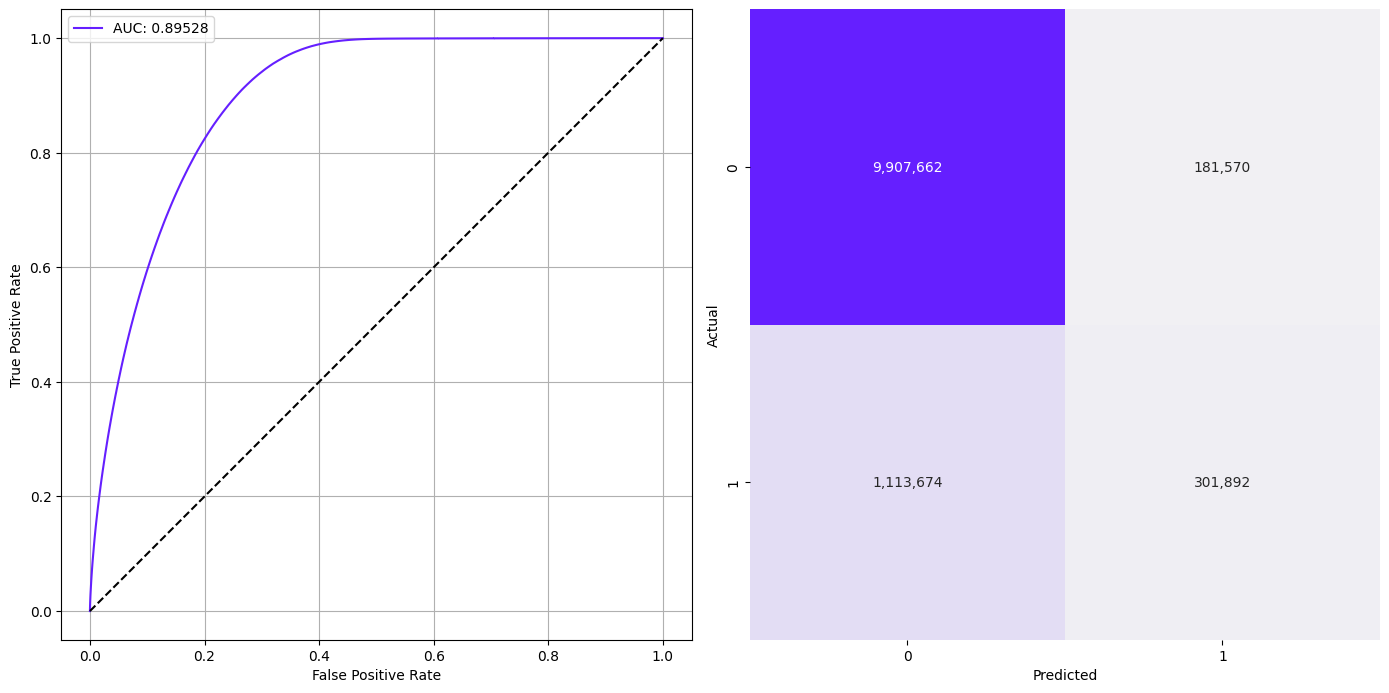

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, stacking_oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(stacking_scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = stacking_oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()